In [1]:
!pip install seaborn --upgrade

    100% |████████████████████████████████| 215kB 25.9MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


# Lecture 17: Newton's method

In the last lecture we saw that, even after implementing a reasonable [line search](https://en.wikipedia.org/wiki/Line_search) method, it can take a long time for gradient descent algorithms to approach the minimum of a function. One example where this can happen is in multidimensional functions where the curvature along different dimensions is significantly unbalanced. 

[Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) can help us to get around this specific problem by taking the curvature of the function into account. This method works by expanding the function $f(\underline{x})$ to second order,

$$
f(\underline{x} + \underline{s}) = f(\underline{x}) + \underline{s}^T\nabla f(\underline{x}) + \underline{s}^T \nabla^2 f(\underline{x}) \underline{s}\,.
$$

We can then solve for the step direction $\underline{s}$ that minimizes the function. The resulting step direction is called the **Newtwon direction**,

$$
\underline{s}_N = -\left[\nabla^2 f(\underline{x})\right]^{-1} \nabla f(\underline{x})\,.
$$

Note that this direction is different from the steepest descent direction! One interesting feature of Newton's method is that, unlike steepest descent, the equation above sets a "natural" step length. 


### Example: Optimizing an unbalanced quadratic function

Let's return to the example that gave us trouble last time: a two-dimensional quadratic function, 

$$
f(\underline{x}) = a_1 x_1^2 + a_2 x_2^2\,,
$$

with $a_1 = 1$ and $a_2 = 1000$. This function is clearly imbalanced -- deviations from zero are penalized much more strongly for the second dimension than for the first. As a result, it becomes harder to effectively "move" the parameters along the first dimension with gradient descent. Let's begin to explore this by plotting the function.

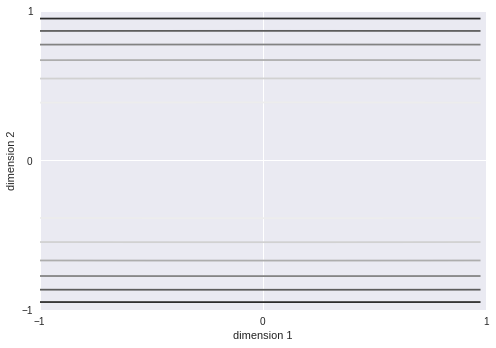

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Define the quadratic function

a = np.array([1., 1000.])

def f(x):
    return np.sum(a * (x**2))


# Plot the function

delta = 0.025
x = np.arange(-1.0, 1.0, delta)
y = np.arange(-1.0, 1.0, delta)
X, Y = np.meshgrid(x, y)
Z = (a[0]*X**2) + (a[1]*Y**2)

plt.contour(X, Y, Z)
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
plt.xlabel('dimension 1')
plt.ylabel('dimension 2');

We have to go a huge distance in the first dimension to change the function by the same amount as we get if we go just a small distance in the second dimension. This means that the derivatives are dominated by the second dimension, since they are perpendicular to the [level sets](https://en.wikipedia.org/wiki/Level_set) of the function in the above plot.

### Comparing the step directions

Let's examine this more carefully by explicitly computing the steepest descent direction, starting from the point $(0.9, 0.9)$.

In [4]:
# Define the derivative function

def df(x):
    return 2*a*x


# Compute the steepest descent direction

x0 = np.array([0.9, 0.9])
s  = -df(x0) # FILL THIS IN

print('The steepest descent direction is {}'.format(s))

The steepest descent direction is [   -1.8 -1800. ]


As you can see, the steepest descent direction is pointed almost entirely along the second dimension. If we update the parameters in this direction, we will make little progress toward the minimum along the first dimension.

Now, let's compute the Newton direction. This is more complicated because now we need to compute the **matrix** of second derivatives of our function (sometimes called the [Hessian](https://en.wikipedia.org/wiki/Hessian_matrix)), take its inverse, and multiply by the vector of derivatives:

$$
\underline{s}_N = -\left[\nabla^2 f(\underline{x})\right]^{-1} \nabla f(\underline{x})\,.
$$

In [9]:
# Get the matrix of second derivatives

def ddf(x):
    return np.diag(2*a) # diagonal 2x2 matrix with 2a on the diagonal!


# Now compute the Newton direction

x0  = np.array([0.9, 0.9])
s_N = -np.matmul(np.linalg.inv(ddf(x0)), df(x0)) # FILL THIS IN

print('The Newton direction is {}'.format(s_N))

The Newton direction is [-0.9 -0.9]


In [8]:
np.diag(a)

array([[   1.,    0.],
       [   0., 1000.]])

Because the function is actually quadratic, Newton's method points **precisely** toward the minimum of the function! More generally, when it can be calculated, the inclusion of curvature in Newton's method can greatly speed convergence. This is especially true in the neighborhood of the minimum (when we are close enough to the minimum, all functions can be well-approximated as quadratic).

### Example: The Rosenbrock function

The [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) is a **non-convex** function that was originally designed for testing optimization algorithms. It is challenging to optimize for the same reasons as the quadratic function above -- the minimum lies in a long, shallow "valley" which is difficult to traverse by following the gradient. It is defined as 

$$
f(\underline{x}) = 100(x_2 − x_1^2)^2 + (1 − x_1)^2\,.
$$

First, let's visualize the function.

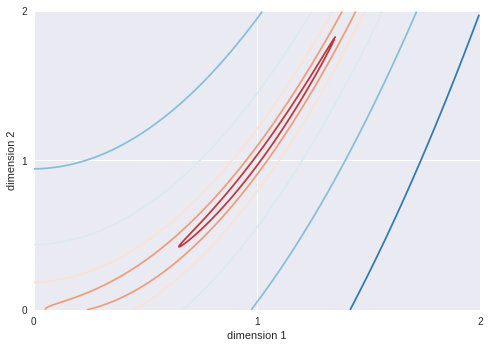

In [11]:
# Define the Rosenbrock function

def f(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2


# Plot the function

delta = 0.005
x = np.arange(0, 2.0, delta)
y = np.arange(0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z = np.log(100 * (Y - X**2)**2 + (1 - X)**2 + 0.1)

plt.contour(X, Y, Z, cmap='RdBu')
plt.xticks([0, 1, 2])
plt.yticks([0, 1, 2])
plt.xlabel('dimension 1')
plt.ylabel('dimension 2');

What would happen if we started at the point $(1.5, 1.5)$ and tried to use steepest descent? Let's compute the steepest descent direction.

In [13]:
# Define the derivative

def df(x):
    return np.array([-400 * (x[1] - x[0]**2) * x[0] - 2 * (1 - x[0]), 200 * (x[1] - x[0]**2)])


# And compute the step direction

x0 = np.array([1.5, 1.5])
s  = -df(x0)

print('The steepest descent direction is {}'.format(s))

The steepest descent direction is [-451.  150.]


### Running gradient descent on the Rosenbrock function

Let's import our gradient descent algorithm -- including the line search -- from last lecture and attempt to minimize the Rosenbrock function.

In [14]:
# Set line search parameters

beta1 = 0.4    # Step size multiplier if sufficient decrease fails
beta2 = 1.2    # Step size multiplier if curvature condition fails
alpha = 0.001  # Sufficient decrease parameter
gamma = 0.5    # Curvature condition parameter


# Set steepest descent parameters

epsilon  = 0.001  # Stopping condition -- end when |df/dx| < epsilon 
max_iter = 100    # Maximum number of iterations
it       = 0      # Current iteration


# Initialize and iteratre

x0   = np.array([1.5, 1.5]) # Starting value of parameter
x    = x0                   # Current value of the parameter
dfdx = df(x0)               # Starting value of the derivative df/dx

# Report status
print('iter\tx1\tx2\tf(x)\tdf/dx1\tdf/dx2')

# Now loop through the steepest descent algorithm

while np.sum(np.fabs(dfdx))>=epsilon and it<max_iter:
    
    # Report status
    print('%d\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f' % (it, x[0], x[1], f(x), dfdx[0], dfdx[1]))
    
    # Choose the step direction
    s = -df(x)
    
    # Choose how far to step in that direction
    t = 1 
    both_passed = False
    
    while not both_passed:

        # Check for sufficient decrease fail

        if f(x + (t*s)) > f(x) + (alpha * t * np.dot(df(x), s)):
            t = beta1 * t

        # If passed, check for curvature condition fail

        elif np.dot(df(x + (t*s)), s) < gamma * np.dot(df(x), s):
            t = beta2 * t

        # If both passed, exit the loop

        else:
            both_passed = True
    
    # Update the parameters
    x = x + t*s
    
    # Update the derivative
    dfdx = df(x)
    
    # Update the iteration counter
    it += 1
    
# Report the minimum
print('\nFound the minimum near x* = (%lf, %lf), true minimum is (1, 1)' % (x[0], x[1]))

iter	x1	x2	f(x)	df/dx1	df/dx2
0	1.500	1.500	56.500	451.000	-150.000
1	1.204	1.598	2.222	-70.723	29.529
2	1.251	1.579	0.084	-6.751	2.899
3	1.255	1.577	0.065	-0.247	0.302
4	1.256	1.577	0.065	0.512	-0.000
5	1.255	1.577	0.065	0.088	0.168
6	1.250	1.566	0.064	-1.608	0.843
7	1.251	1.565	0.063	-0.013	0.206
8	1.251	1.564	0.063	0.475	0.010
9	1.250	1.564	0.063	0.088	0.165
10	1.245	1.554	0.062	-1.698	0.879
11	1.246	1.553	0.061	-0.030	0.209
12	1.246	1.552	0.061	0.548	-0.022
13	1.246	1.552	0.060	0.094	0.159
14	1.243	1.548	0.060	-0.860	0.542
15	1.244	1.548	0.060	0.014	0.190
16	1.244	1.546	0.059	0.800	-0.126
17	1.243	1.546	0.059	0.110	0.152
18	1.242	1.545	0.059	-0.507	0.399
19	1.242	1.544	0.059	0.034	0.182
20	1.241	1.540	0.059	1.281	-0.321
21	1.241	1.540	0.058	0.140	0.137
22	1.240	1.539	0.058	-0.288	0.310
23	1.241	1.539	0.058	0.545	-0.026
24	1.240	1.539	0.058	0.096	0.155
25	1.238	1.535	0.057	-0.972	0.585
26	1.238	1.534	0.057	-0.000	0.193
27	1.238	1.534	0.057	0.392	0.034
28	1.238	1.534	0.057	-0.369	0.3

As promised, we get stuck in the long, shallow basin and we stop making progress.

### Newton's method for the Rosenbrock function

Let's compare this result with the answer from Newton's method. To do this we need to compute the matrix of second derivatives.

In [15]:
# Get the matrix of second derivatives

def ddf(x):
    return np.array([[2 + 800*x[0]**2 - 400*(x[1] - x[0]**2), -400*x[0]], [-400*x[0], 200]])


# Now compute the Newton direction

x0  = np.array([0.7, 1.3])
s_N = - np.matmul( np.linalg.inv(ddf(x0)), df(x0) ) # matrix multiplication

print('The Newton direction is {}'.format(s_N))

The Newton direction is [-0.00186335 -0.8126087 ]


In this case, the step size differs dramatically. Though it is unbalanced, we can observe convergence toward the optimum. 

In [16]:
epsilon  = 0.001  # Stopping condition -- end when |df/dx| < epsilon 
max_iter = 100    # Maximum number of iterations
it       = 0      # Current iteration

x0   = np.array([1.5, 1.5])  # Starting value of parameter
x    = x0                    # Current value of the parameter
dfdx = df(x0)                # Starting value of the derivative df/dx

# Report status
print('iter\tx1\tx2\tf(x)\tdf/dx1\tdf/dx2')

# Now loop through the steepest descent algorithm

while np.sum(np.fabs(dfdx))>=epsilon and it<max_iter:
    
    # Report status
    print('%d\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f' % (it, x[0], x[1], f(x), dfdx[0], dfdx[1]))
    
    # Choose the step direction
    s = -np.matmul( np.linalg.inv(ddf(x)), df(x) )
    
    # Choose how far to step in that direction
    t  = 1
    
    # Update the parameters
    x += t * s
    
    # Update the derivative
    dfdx = df(x)
    
    # Update the iteration counter
    it += 1
    
# Report the minimum
print('\nFound the minimum near x* = (%lf, %lf), true minimum is (1, 1)' % (x[0], x[1]))

iter	x1	x2	f(x)	df/dx1	df/dx2
0	1.500	1.500	56.500	451.000	-150.000
1	1.497	2.240	0.247	1.000	-0.002
2	1.001	0.757	6.033	98.357	-49.124
3	1.001	1.002	0.000	0.002	-0.000

Found the minimum near x* = (1.000000, 0.999999), true minimum is (1, 1)
